# code in progress. see demo.ipynb for working version 

In [1]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import sys


# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

# osse tools package:
# del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

In [2]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
ndays = 31

# directory where data files are stored
# datadir = './data/' # default is ./data
datadir = '/data1/adac/mitgcm/netcdf/' + RegionName +'/'


# optional details for sampling (if not specified, reasonable defaults will be used)
# ** not implemented **
sampling_details = {
    'SAMPLING_STRATEGY' : 'sim_mooring', # options: sim_glider, sim_uctd or trajectory_file.add: mooring, ASV
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
    'hspeed' : 0.25,  # platform horizontal speed in m/s
    'vspeed' : 0.1, # platform vertical (profile) speed in m/s 
    'trajectory_file' : None, # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'repeat' # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
}



# --------------------------------------------------------------------

#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. The data from the model were retrieved using download_llc4320.ipynb and saved locally.

In [ ]:
# download files:
download_llc4320_data(RegionName, datadir, start_date, ndays)

# derive & save new files with steric height & vorticity
compute_derived_fields(RegionName, datadir, start_date, ndays)

In [4]:
# Load all model data files  
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
ds = xr.open_mfdataset(target_files, parallel=True)

# load the corresponding derived fields
derivedir = datadir + 'derived/'
derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
dsd = xr.open_mfdataset(derived_files)

# merge the derived and raw data
ds = ds.merge(dsd)

# Change time from datetime to integer
ds = ds.assign_coords(time=np.linspace(0,ds.time.size-1, num=ds.time.size)) # time is now in hours

# Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
# XC, YC and Z are the same at all times, so select a single time
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

### Create & plot sampling track

In [425]:
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp
sampling_details['SAMPLING_STRATEGY']='sim_glider'
sampling_details['SAMPLING_STRATEGY']='sim_mooring'
# *** can't change sampling_details here :(
# sampling_details['zmooring_TS'] = [-0.5]
# sampling_details['xmooring'] = [ds.XC.sel(i=0,j=0,time=0).values]
# sampling_details['ymooring'] = [ds.YC.sel(i=0,j=0,time=0).values]


survey_track, survey_indices, sampling_parameters = get_survey_track(ds, sampling_details)


### Visualizations

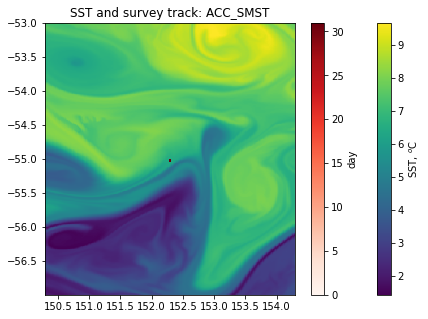

In [360]:
## Visualize track over a single model snapshot:
%matplotlib inline
plt.figure(figsize=(7,5))
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
tracko = plt.scatter(survey_track.lon, survey_track.lat, c=survey_track.time, cmap='Reds', s=0.75)
plt.title('SST and survey track: ' + RegionName)
plt.colorbar(ssto).set_label('SST, $^o$C')
plt.colorbar(tracko).set_label('day')
plt.show()

### Interpolate data with the specified sampling pattern (this is where the magic happens!)

In [426]:
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp
sdata, sh_true = survey_interp(ds, survey_track, survey_indices)


### Visualize interpolated data in 3D

In [427]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(sdata.lon.data, sdata.lat.data, sdata.dep.data, c=sdata.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')

Text(0.5, 0.92, 'Temperature interpolated to the survey track')

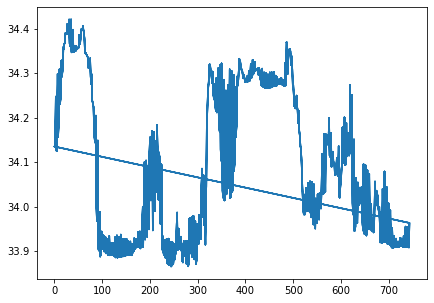

In [435]:
%matplotlib inline
plt.figure(figsize=(7,5))
# plt.scatter(sdata.time, sdata.dep, c=sdata.Theta.data)           
# # plt.colorbar()

plt.plot(sdata.time,sdata.Salt.data,'-')


1


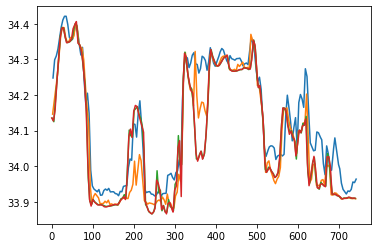

In [437]:
# "sdata" is on points- not that useful! interpolate to a regular#
# time/depth grid, which comes from the unique values of 
# all times/depths in sdata.
# (works for mooring, but prob not glider or uctd???)
tgr = np.unique(sdata.time)
zgr = np.unique(sdata.dep)
(tm, zm) = np.meshgrid(tgr, zgr)
dum = griddata((sdata.time.data, sdata.dep.data), sdata.Salt.data, (tm, zm), method='linear')
plt.plot(tgr,np.transpose(dum),'-')
print(1)

In [436]:
# ALTERNATIVE METHOD to survey_interp:
# ?? interpolate to a set of i.j.k rather than interpolating to "points" and then reshaping/interpolating
# --> slower
dsi = xr.Dataset()
vbls3d = ['Theta','Salt','vorticity','steric_height']
for vbl in vbls3d:
    # lazy & fast
    dsi[vbl] = ds[vbl].interp(i=np.unique(sdata.i), j=np.unique(sdata.j), k=np.unique(sdata.k))


# actual computation, so it's the slow part 
sss = dsi.Salt.values

In [442]:
# plot to compare the two methods 
# ( not quite working )
tpl = ds['time']/24,sss[:,0,0,0]
ttt=ds['time']
# ipl = ( sdata.dep.values == sdata.dep.values.min() )

# plt.plot(sdata.time(ipl),sdata.Salt.sel(ipl).data,'-')
plt.plot(ttt[:],sss[:,0,0,0],'--')
# plt.legend('survey_interp method','direct interpolation')

TypeError: 'DataArray' object is not callable

### Visualize steric height

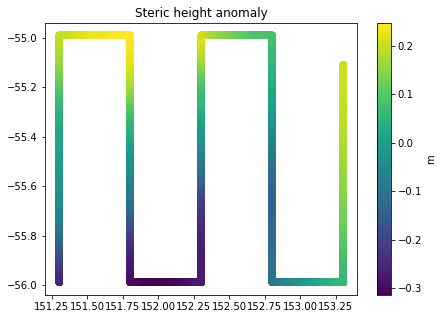

In [9]:
%matplotlib inline
sh_anom = sh_true.values - sh_true.values.mean()
plt.figure(figsize=(7,5))
sho = plt.scatter(survey_track.lon, survey_track.lat, c=sh_anom)
plt.title('Steric height anomaly')
plt.colorbar(sho).set_label('m')
plt.show()

### Comparison of true vs sampled steric height
Plot comparing the "true" steric height along the track and the subsampled steric height, which is computed by integrating the specific volume anomaly for each subsampled profile from its deepest sampling depth

Text(0, 0.5, 'steric height anom., m')

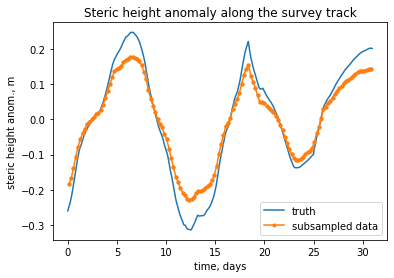

In [10]:
%matplotlib inline

# truth:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# get index of the deepest sampling depths
i = ( sdata.dep.values == sdata.dep.values.min() )
plt.plot(sdata.time.values[i], sdata.steric_height.values[i] - sdata.steric_height.values[i].mean(),'.-')
plt.title('Steric height anomaly along the survey track')
plt.legend(['truth','subsampled data'])
plt.xlabel('time, days')
plt.ylabel('steric height anom., m')

In [11]:
# NEW CODE  BELOW

# interpolation:
subsampled_data = xr.Dataset()  

# loop & interpolate through 3d variables:
vbls3d = ['Theta','Salt','vorticity']
# vbls3d = ['Theta']
for vbl in vbls3d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices)
# # Interpolate U and V from i_g, j_g to i, j, then interpolate:
# U_c = grid.interp(ds.U, 'X', boundary='extend')
# V_c = grid.interp(ds.V, 'Y', boundary='extend')
# subsampled_data['U'] = U_c.interp(survey_indices)
# subsampled_data['V'] = V_c.interp(survey_indices)

subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time 

# loop & interpolate through 2d variables:
vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY']
vbls2d = ['Eta', 'Depth']
# create 2-d survey track by removing the depth dimension
survey_indices_2d =  survey_indices.drop_vars('k')
for vbl in vbls2d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)
# survey_indices_2d.i.plot()
# ds['KPPhbl'].interp(survey_indices_2d).plot()

# interp
# this returns a value at every timestep (points) - very high resolution
# - could subsample to the model time grid 


# plot
# plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# plt.plot(subsampled_data.time, ssh - ssh.mean())


In [12]:
subsampled_data = xr.Dataset() 

# loop & interpolate through 3d variables:
vbls3d = ['Theta','Salt','vorticity','steric_height']
for vbl in vbls3d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices)
# Interpolate U and V from i_g, j_g to i, j, then interpolate:
# Get u, v
grid = Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                        'Y':{'center': 'j', 'left': 'j_g'},
                        'Z':{'center': 'k'}})
U_c = grid.interp(ds.U, 'X', boundary='extend')
V_c = grid.interp(ds.V, 'Y', boundary='extend')
subsampled_data['U'] = U_c.interp(survey_indices)
subsampled_data['V'] = V_c.interp(survey_indices)


# add lat/lon/time to dataset
subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time  

# loop & interpolate through 2d variables:
vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
# create 2-d survey track by removing the depth dimension
survey_indices_2d =  survey_indices.drop_vars('k')
for vbl in vbls2d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)   
# taux & tauy must be treated like U and V
oceTAUX_c = grid.interp(ds.oceTAUX, 'X', boundary='extend')
oceTAUY_c = grid.interp(ds.oceTAUY, 'Y', boundary='extend')
subsampled_data['oceTAUX'] = oceTAUX_c.interp(survey_indices_2d)
subsampled_data['oceTAUY'] = oceTAUY_c.interp(survey_indices_2d)


    

In [13]:
ds.U

,Array,Chunk
Bytes,15.60 GiB,515.32 MiB
Shape,"(744, 84, 349, 192)","(24, 84, 349, 192)"
Count,93 Tasks,31 Chunks
Type,float32,numpy.ndarray


NameError: name 'ssh' is not defined

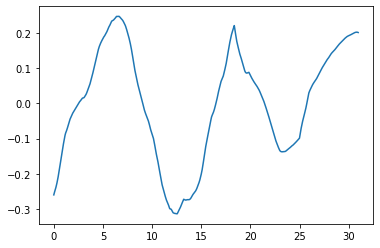

In [14]:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
plt.plot(subsampled_data.time, ssh - ssh.mean())


In [ ]:
# mooring test

model_xav = ds.XC.cccc.mean(dim='i').values
model_yav = ds.YC.isel(time=0, i=0).mean(dim='j').values

xmooring = model_xav # default lat/lon is the center of the domain
ymooring = model_yav
zmooring_TS = [-1, -10, -50, -100] # depth of T/S instruments
zmooring_UV = [-1, -10, -50, -100, -200, -300, -400, -500] # depth of U/V instruments


ts = ds.time
n_samples = ts.size
n_depths_TS = np.size(zmooring_TS)
n_depths_UV = np.size(zmooring_UV)
# depth sampling - different for TS and UV
zs_TS = np.transpose(np.tile(zmooring_TS,(n_samples,1)))
zs_UV = np.transpose(np.tile(zmooring_UV,(n_samples,1)))
xs_TS = xmooring * np.ones([n_depths_TS, n_samples])
ys_TS = ymooring * np.ones([n_depths_TS, n_samples])
xs_UV = xmooring * np.ones([n_depths_TS, n_samples])
ys_UV = ymooring * np.ones([n_depths_TS, n_samples])

survey_track = xr.Dataset(
    dict(
        lon = xr.DataArray(xs_TS,dims='points'),
        lat = xr.DataArray(ys_TS,dims='points'),
        dep = xr.DataArray(zs_TS,dims='points'),
        time = xr.DataArray(ts_TS,dims='points')
    )
)



In [ ]:
# np.broadcast_to([-1, -10, -50, -100],(2,4))
np.broadcast_to([-1, -10, -50, -100],(2,4))

In [ ]:
# np.broadcast_to(zmooring_TS,(2,4))
# np.tile(zmooring_TS.transpose,(2,1))
# np.tile(np.transpose(zmooring_TS),(1,n_samples)).shape
# xs_TS.shape
# [-1, -10, -50, -100]
# zmooring_TS

# np.transpose(np.array(zmooring_TS)).shape 
np.transpose(np.tile(zmooring_TS,(n_samples,1))).shape
xs_TS.shape

In [ ]:
sdata

In [ ]:
plt.scatter(subsampled_data.time,subsampled_data.dep,c=subsampled_data.Theta)
plt.plot(subsampled_data.time,-subsampled_data.Depth,c='r')

In [ ]:
sh_true.plot()

In [ ]:

# we interpolated everything to the "points" - one datapoint per sample
# but we may also want a cleaner (gridded) output product that has been reshaped into 
# profiles (i.e., a X x Z x T array)
# (This might not make sense for glider data, since profiles are likely > one model gridpoint)

# separate these into "subsampled_points" and "subsampled_profiles"?

# a couple ways to determine the profiles:
# - one per down / one per up, with time as either the start/mean/end
# - one per down-up, with the time as the deepest point
# - maybe others? would be useful to get feedback on this...

# use "where" to determine the indices of the start/end (shallowest/deepest) of each profile:

# subsampled_data.steric_height.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)
# subsampled_deepest = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)

# plt.plot(subsampled_data.dep.values[ideep])

# this is the DEEPEST point only. 
dum = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)
shall = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.max(), drop=True)

# plt.plot(dum.lon,dum.lat,'.')
# plt.plot(shall.lon,shall.lat,'.')

shall

In [ ]:
import time
# index?
ishallow = ( subsampled_data.dep.values == subsampled_data.dep.values.max() )
ideep = ( subsampled_data.dep.values == subsampled_data.dep.values.min() )
# boolean to index
ishallow = [ishallow for ishallow, x in enumerate(ishallow) if x]
ideep = [ideep for ideep, x in enumerate(ideep) if x]

t_profiles = subsampled_data['time'].isel(points=ishallow)
t_profiles.plot()

# # initialize the dataset:
subsampled_profile = xr.Dataset(
    coords={
        "time": t_profiles,
    }    
)


# n [35]: ds = xr.Dataset(
#    ....:     {
#    ....:         "temperature": (["x", "y", "time"], temp),
#    ....:         "precipitation": (["x", "y", "time"], precip),
#    ....:     },
#    ....:     coords={
#    ....:         "lon": (["x", "y"], lon),
#    ....:         "lat": (["x", "y"], lat),
#    ....:         "time": pd.date_range("2014-09-06", periods=3),
#    ....:         "reference_time": pd.Timestamp("2014-09-05"),
#    ....:     },
#    ....: )
#    ....: 
        
        
        
# # loop through each profile:

# for n in np.arange(np.size(ishallow)):
#     i = np.arange(ishallow[n],ideep[n])
#     # loop & interpolate through 3d variables:
#     for vbl in vbls3d:
# #         subsampled_profile[vbl] = subsampled_data[vbl].isel(points=i)
#         dum = subsampled_data[vbl].isel(points=i)

    
    
# # n=0
# # i = np.arange(ishallow[n],ideep[n])
# # start = time.time()
# # dum = subsampled_data.Theta.isel(points=i)
# # end = time.time()
# # print("The time of execution of above program is :", end-start)